<a href="https://colab.research.google.com/github/veruizr/ML_Doc/blob/main/ML_fourbar_mechanisms_open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Planteamiento de algoritmos de Machine Learning para análisis de posición de mecanismos de 4 barras


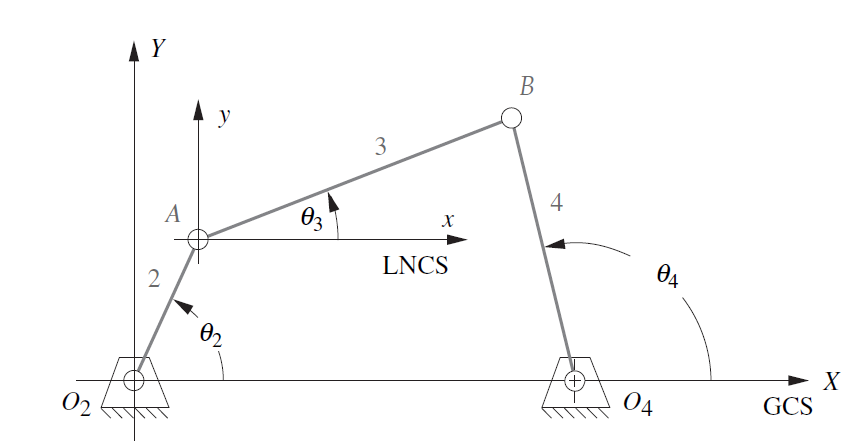

## 1. Descripción del problema
El objetivo es predecir los ángulos
*θ3* (acoplador) y *θ4* (salida) de un mecanismo de 4 barras a partir de:

Longitudes de los eslabones:
*L1,L2,L3,L4*

 Ángulo de entrada:
*θ2*

## 2. Construcción del conjunto de datos
Se utilizó el software *Working Model 2D* para simular gráficamente diferentes configuraciones de mecanismos de acuerdo con la distribución de inversiones de Barker (Norton (2004)), variando las longitudes de los eslabones para diferentes posiciones del ángulo de entrada  *θ2* entre 0 y π rads. se exportaron los datos de cada simulación y se fusionaron en un solo archivo. se obtuvieron en total 10458 datos.



##3. Planteamiento de la solución

Como estrategia de solución del problema se plantea la construcción de una red neuronal que aprenda del conjunto de datos de múltiples configuraciones del mecanismo y una vez entrenada tenga la posibilidad de predecir los valores de los ángulos de acoplador y salida en una configuración abierta del mecanismo.

###3.1 Definición de la arquitectura de la red
**Entradas**:

5 entradas L1,L2,L3,L4 y θ2

**capas ocultas**
2 capas ocultas con 128 y 64 neuronas y activación ReLU.

**Salidas:**
 2 neuronas lineales (para θ3 y θ4).

 Se usarán técnicas de normalización y escalado de los datos y se utilizará del conjunto de datos, el 80% para entrenamiento y el 20% para prueba.

## 4. Estrategia de solución usando pytorch


###4.1 Cargar dataset para el análisis usando pandas

In [ ]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_csv('datasetbarker_ok.csv')
# Mostrar primeras filas para verificar
print("Dataset cargado:\n", df.head())

# Selección de variables
X = df[['L1', 'L2', 'L3', 'L4', 'theta_2']].values
y = df[['theta_3', 'theta_4']].values
#comprobar la configuración de entradas y salidas
print("Forma de X:", X.shape)  # Debe ser (n_muestras, 5)
print("Forma de y:", y.shape)  # Debe ser (n_muestras, 2)

Dataset cargado:
       L1     L2     L3     L4  theta_2  theta_3  theta_4
0  210.0  400.0  500.0  650.0    0.336   -0.267    0.000
1  210.0  400.0  500.0  650.0    0.339   -0.264    0.004
2  210.0  400.0  500.0  650.0    0.342   -0.260    0.008
3  210.0  400.0  500.0  650.0    0.345   -0.257    0.012
4  210.0  400.0  500.0  650.0    0.348   -0.254    0.016
Forma de X: (9758, 5)
Forma de y: (9758, 2)


### 4.2 Normalización de los datos y división de datos de porcentaje para  entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalización
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("X escalado (ejemplo):\n", X_train_scaled[0])
print("y escalado (ejemplo):\n", y_train_scaled[0])

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)

X escalado (ejemplo):
 [-0.58380334 -1.08698807  1.99544713 -0.71054983 -3.20080129]
y escalado (ejemplo):
 [-0.14612166 -0.66499282]
Tamaño de X_train: (7806, 5)
Tamaño de X_test: (1952, 5)


### 4.3 Implementación usando pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class FourBarNN(nn.Module):
    def __init__(self):
        super(FourBarNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Salida: theta_3 y theta_4
        )

    def forward(self, x):
        return self.net(x)

# Instanciar el modelo
model = FourBarNN()


### 4.4 Entrenamiento y evaluación del modelo

In [ ]:
# Conversión a tensores
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test_scaled, dtype=torch.float32)

# Parámetros de entrenamiento
optimizer = optim.Adam(model.parameters(), lr=0.001) # Optimizador
criterion = nn.MSELoss()  #Función de pérdida
epochs = 500

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Prueba del modelo
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_torch)
        test_loss = criterion(test_outputs, y_test_torch)
        test_losses.append(test_loss.item())


### 4.5 visualización del entrenamiento y prueba

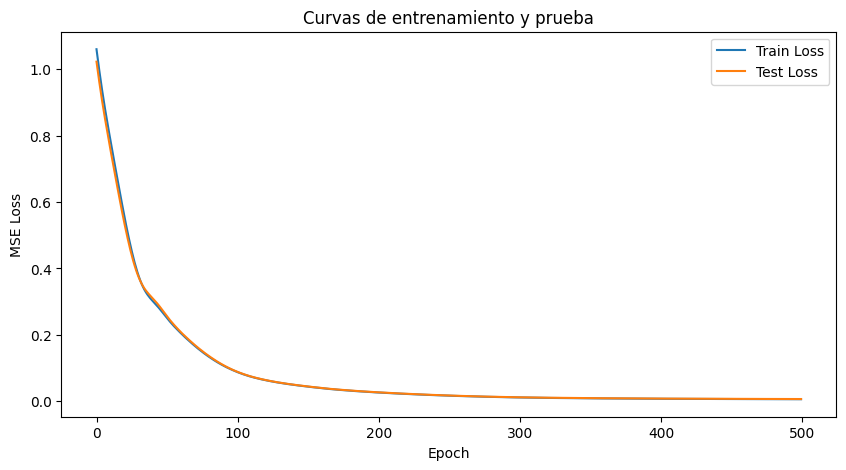

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Curvas de entrenamiento y prueba')
plt.show()


###4.6 Evaluación del modelo

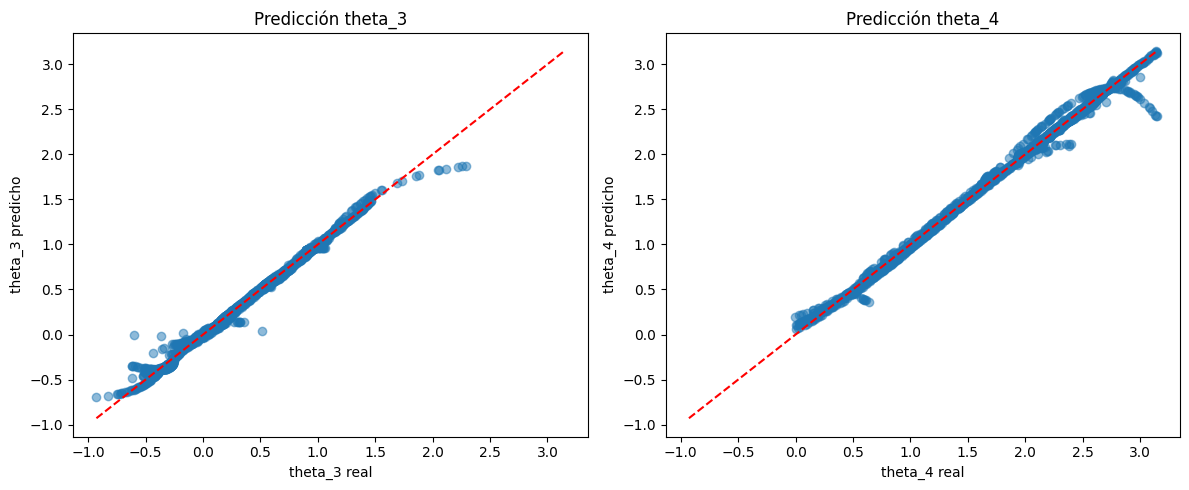

In [ ]:
# Predicción y desnormalización
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_torch).numpy()
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    y_true = scaler_y.inverse_transform(y_test_torch.numpy())

# Gráficas de dispersión
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_true[:,0], y_pred[:,0], alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('theta_3 real')
plt.ylabel('theta_3 predicho')
plt.title('Predicción theta_3')

plt.subplot(1,2,2)
plt.scatter(y_true[:,1], y_pred[:,1], alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel('theta_4 real')
plt.ylabel('theta_4 predicho')
plt.title('Predicción theta_4')
plt.tight_layout()
plt.show()


### 4.7 Guardar el modelo y los escaladores para utilizarlo posteriormente

In [ ]:
# Guardar el modelo y los escaladores utilizando joblib
import joblib
#torch.save(model, 'modelo_fourbar.pth')
torch.save(model.state_dict(), 'modelo_fourbar.pth')
#joblib.dump(model, "modelo_fourbar.pkl")
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

print("Modelo y escaladores guardados exitosamente.")

Modelo y escaladores guardados exitosamente.


##5.Implementación con scikit-learn (Sklearn)

###5.1 Carga de datos y división y normalización

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar datos
df = pd.read_csv('datasetbarker_ok.csv')

# Definir variables
X = df[['L1', 'L2', 'L3', 'L4', 'theta_2']]
y = df[['theta_3', 'theta_4']]

# División y normalización
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("X escalado (ejemplo):\n", X_train_scaled[0])
print("y escalado (ejemplo):\n", y_train_scaled[0])

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)

X escalado (ejemplo):
 [-0.58380334 -1.08698807  1.99544713 -0.71054983 -3.20080129]
y escalado (ejemplo):
 [-0.14612166 -0.66499282]
Tamaño de X_train: (7806, 5)
Tamaño de X_test: (1952, 5)


###5.2 Implementación red neuronal en sklearn

In [ ]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=(64, 64),  # Dos capas ocultas con 64 neuronas
    activation='relu',
    solver='adam',
    max_iter=500, #iteraciones (épocas en pytorch)
    random_state=42
)

model.fit(X_train_scaled, y_train_scaled) #entrenamiento de la red neuronal


MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)

### 5.3 Prueba y evaluación del modelo

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predicciones
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_scaled)

# Métricas
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
print(f'MSE: {mse:.4f}, R²: {r2:.4f}')



MSE: 0.0023, R²: 0.9947


###5.4 gráficas de evaluación

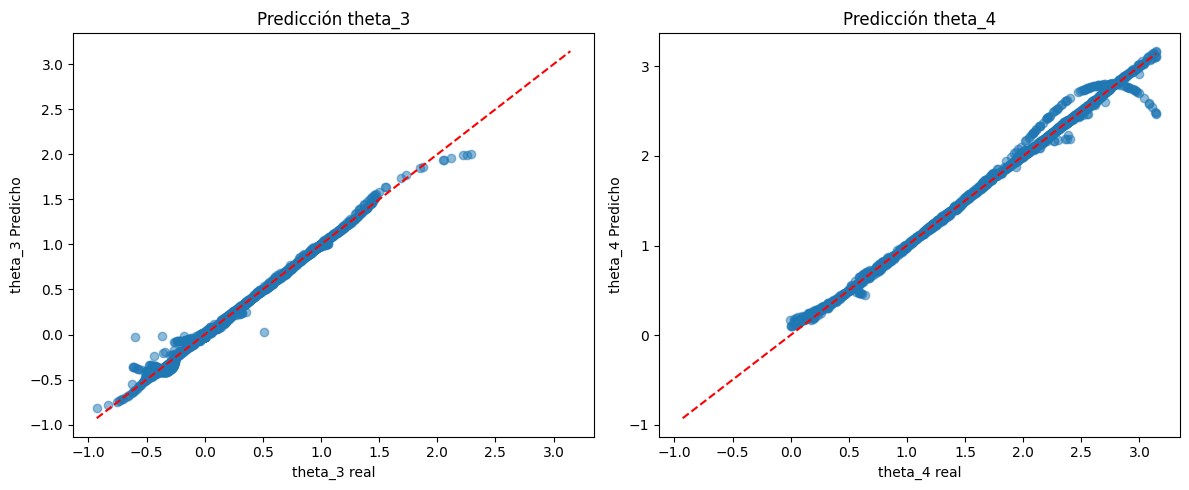

In [ ]:
import matplotlib.pyplot as plt

# Predicciones vs reales
plt.figure(figsize=(12,5))
for i, angle in enumerate(['theta_3', 'theta_4']):
    plt.subplot(1,2,i+1)
    plt.scatter(y_true[:,i], y_pred[:,i], alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel(f'{angle} real')
    plt.ylabel(f'{angle} Predicho')
    plt.title(f'Predicción {angle}')
plt.tight_layout()
plt.show()


In [ ]:
#Guardar el modelo y los escaladores utilizando joblib
import joblib
joblib.dump(model, "modelo_fourbarskl.pkl")
joblib.dump(scaler_X, "scaler_Xskl.pkl")
joblib.dump(scaler_y, "scaler_yskl.pkl")

print("Modelo y escaladores guardados exitosamente.")

Modelo y escaladores guardados exitosamente.


## 6. Predicción usando los modelos

In [ ]:
import pandas as pd
import numpy as np
import joblib
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)

# Carga de dataset para predicción DSPREDICCION.csv
df = pd.read_csv("DSPREDICCION.csv",delimiter=';')
df.columns = ['L1', 'L2', 'L3', 'L4', 'theta_2', 'theta_3', 'theta_4']
X = df[["L1", "L2", "L3", "L4", "theta_2"]].values
y_true = df[["theta_3", "theta_4"]].values  # se guardan los valores reales para comparar con las predicciones de los modelos

print("Dataset cargado:\n", df)
print("Forma de X:", X.shape)  # Debe ser (n_muestras, 5)
print("Forma de y:", y_true.shape)  # Debe ser (n_muestras, 2)

Dataset cargado:
      L1   L2   L3   L4  theta_2  theta_3  theta_4
0   700  350  500  600    0.500    0.997    1.774
1   750  540  610  450    1.910    5.789    2.630
2   540  200  700  380    2.282    0.332    1.594
3   650  350  340  450    0.681    0.684    1.828
4   950  650  725  340    0.436    5.991    0.195
5   435  550  645  290    1.710    0.586    1.302
6  1000  525  455  750    2.589    6.000    2.589
7   950  340  725  650    3.142    0.334    2.767
8   750  650  400  540    0.915    0.057    1.486
9   650  250  640  250    0.747    0.016    0.747
Forma de X: (10, 5)
Forma de y: (10, 2)


###6.1 predicción usando el modelo sklearn

In [ ]:
# Predicción con el modelo de sklearn
sk_model   = joblib.load("modelo_fourbarskl.pkl")
scaler_X_sk = joblib.load("scaler_Xskl.pkl")
scaler_y_sk = joblib.load("scaler_yskl.pkl")

X_sk_s = scaler_X_sk.transform(X)
y_sk_s = sk_model.predict(X_sk_s)
y_pred_sk = scaler_y_sk.inverse_transform(y_sk_s)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


### 6.2 Predicción usando modelo en pytorch

In [ ]:
class FourBarNN(nn.Module):
    def __init__(self):
        super(FourBarNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Salida: theta_3 y theta_4
        )

    def forward(self, x):
        return self.net(x)

# Instanciar el modelo
pt_model = FourBarNN()
pt_model.load_state_dict(torch.load("modelo_fourbar.pth"))
pt_model.eval()
scaler_X_pt = joblib.load("scaler_X.pkl")
scaler_y_pt = joblib.load("scaler_y.pkl")

X_pt_s = scaler_X_pt.transform(X)
X_pt_t = torch.tensor(X_pt_s, dtype=torch.float32)
with torch.no_grad():
    y_pt_s = pt_model(X_pt_t).numpy()
y_pred_pt = scaler_y_pt.inverse_transform(y_pt_s)


###6.4 Errores elementales
Se calcula la diferencia entre la predicción y el valor real establecido,
se calcula el error absoluto en porcentaje, cuando theta3 o thheta 4 reales son 0 rads hay una dicisión por cero y el error tiende a infinito

   Configuración  theta3_real  sk_theta3_pred  sk_theta3_error  \
0              1        0.997        1.177402         0.180402   
1              2        5.789       -0.878757        -6.667757   
2              3        0.332        0.455076         0.123076   
3              4        0.684        0.962235         0.278235   
4              5        5.991       -1.804050        -7.795050   
5              6        0.586       -0.536644        -1.122644   
6              7        6.000        0.679657        -5.320343   
7              8        0.334       -0.299546        -0.633546   
8              9        0.057        0.162465         0.105465   
9             10        0.016        0.032694         0.016694   

   pt_theta3_pred  pt_theta3_error  
0        1.206324         0.209324  
1       -0.266136        -6.055136  
2        1.285278         0.953279  
3        0.800981         0.116981  
4       -0.689403        -6.680403  
5       -0.617215        -1.203215  
6        0.742

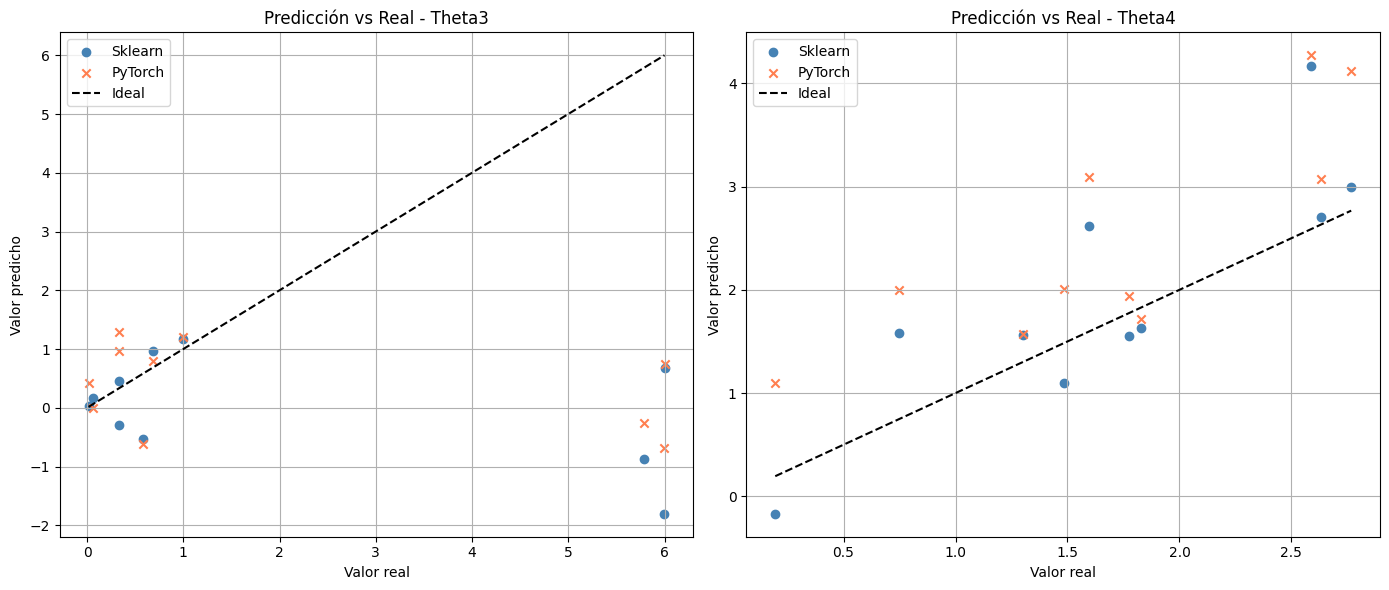

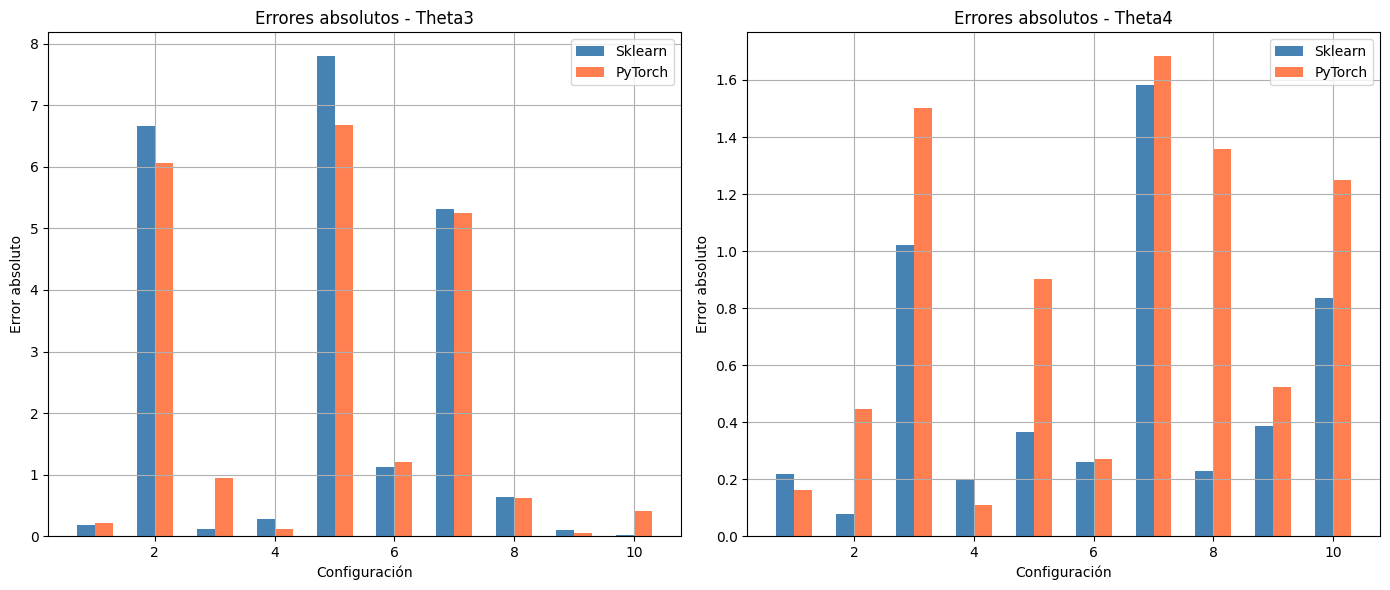

<ipython-input-73-611813ab0620>:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Modelo_Ángulo", y="Error absoluto", data=error_melted, palette="Set2")


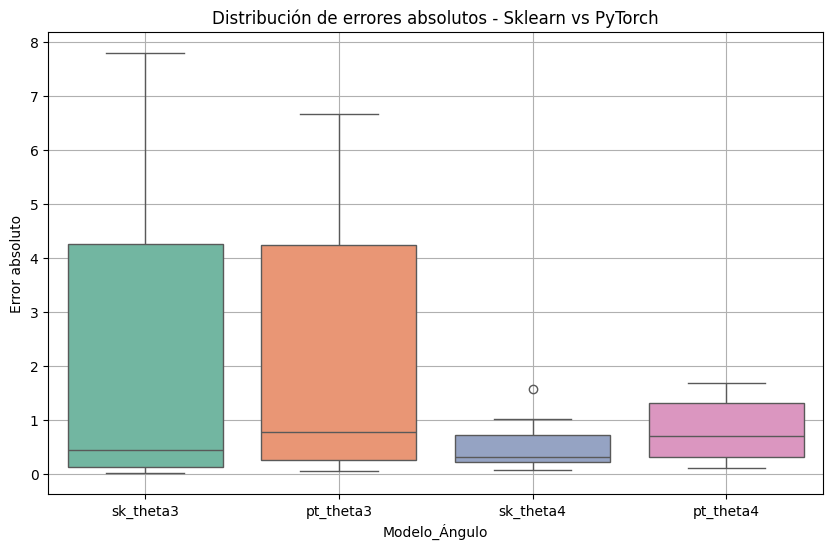

In [ ]:
#import matplotlib.pyplot as plt
import seaborn as sns

#Calcular errores elementales
#se restan los valores reales de theta3 y theta4 de los
# resultados de las predicciones para theta3 y theta 4 en cada modelo
errors = {
    "sk_theta3": y_pred_sk[:,0] - y_true[:,0],
    "sk_theta4": y_pred_sk[:,1] - y_true[:,1],
    "pt_theta3": y_pred_pt[:,0] - y_true[:,0],
    "pt_theta4": y_pred_pt[:,1] - y_true[:,1],
}
# Crear DataFrames para presentación
#tabla general para exportar
tabla_resultados = pd.DataFrame({
    "Configuración": np.arange(1, len(y_true)+1),
    "theta3_real": y_true[:, 0],
    "theta4_real": y_true[:, 1],
    "sk_theta3_pred": y_pred_sk[:, 0],
    "sk_theta4_pred": y_pred_sk[:, 1],
    "pt_theta3_pred": y_pred_pt[:, 0],
    "pt_theta4_pred": y_pred_pt[:, 1],
    "sk_theta3_error": errors["sk_theta3"],
    "sk_theta4_error": errors["sk_theta4"],
    "pt_theta3_error": errors["pt_theta3"],
    "pt_theta4_error": errors["pt_theta4"],
})
#tabla para theta3
tabla_resultados_theta3 = pd.DataFrame({
    "Configuración": np.arange(1, len(y_true)+1),
    "theta3_real": y_true[:, 0],
    "sk_theta3_pred": y_pred_sk[:, 0],
    "sk_theta3_error": errors["sk_theta3"],
    "pt_theta3_pred": y_pred_pt[:, 0],
    "pt_theta3_error": errors["pt_theta3"],
})
#tabla para theta4
tabla_resultados_theta4 = pd.DataFrame({
    "Configuración": np.arange(1, len(y_true)+1),
    "theta4_real": y_true[:, 1],
    "sk_theta4_pred": y_pred_sk[:, 1],
    "sk_theta4_error": errors["sk_theta4"],
    "pt_theta4_pred": y_pred_pt[:, 1],
    "pt_theta4_error": errors["pt_theta4"],
})

# Redondear para mejor lectura
tabla_resultados = tabla_resultados.round(6)
tabla_resultados_theta3 = tabla_resultados_theta3.round(6)
tabla_resultados_theta4 = tabla_resultados_theta4.round(6)

# Mostrar tabla
print(tabla_resultados_theta3)
print(tabla_resultados_theta4)

#gráfico de dispersión de valores
# Gráficos para theta3 y theta4 - sklearn vs pytorch
plt.figure(figsize=(14, 6))

# Theta3
plt.subplot(1, 2, 1)
plt.scatter(y_true[:, 0], y_pred_sk[:, 0], label="Sklearn", color="steelblue", marker="o")
plt.scatter(y_true[:, 0], y_pred_pt[:, 0], label="PyTorch", color="coral", marker="x")
plt.plot([min(y_true[:,0]), max(y_true[:,0])], [min(y_true[:,0]), max(y_true[:,0])], 'k--', label="Ideal")
plt.title("Predicción vs Real - Theta3")
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.legend()
plt.grid(True)

# Theta4
plt.subplot(1, 2, 2)
plt.scatter(y_true[:, 1], y_pred_sk[:, 1], label="Sklearn", color="steelblue", marker="o")
plt.scatter(y_true[:, 1], y_pred_pt[:, 1], label="PyTorch", color="coral", marker="x")
plt.plot([min(y_true[:,1]), max(y_true[:,1])], [min(y_true[:,1]), max(y_true[:,1])], 'k--', label="Ideal")
plt.title("Predicción vs Real - Theta4")
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# Tamaño del gráfico y estilos
plt.figure(figsize=(14, 6))
x = tabla_resultados["Configuración"]
# errores absolutos
# Errores theta3
plt.subplot(1, 2, 1)
plt.bar(x - 0.15, tabla_resultados["sk_theta3_error"].abs(), width=0.3, label="Sklearn", color="steelblue")
plt.bar(x + 0.15, tabla_resultados["pt_theta3_error"].abs(), width=0.3, label="PyTorch", color="coral")
plt.title("Errores absolutos - Theta3")
plt.xlabel("Configuración")
plt.ylabel("Error absoluto")
plt.legend()
plt.grid(True)

# Errores theta4
plt.subplot(1, 2, 2)
plt.bar(x - 0.15, tabla_resultados["sk_theta4_error"].abs(), width=0.3, label="Sklearn", color="steelblue")
plt.bar(x + 0.15, tabla_resultados["pt_theta4_error"].abs(), width=0.3, label="PyTorch", color="coral")
plt.title("Errores absolutos - Theta4")
plt.xlabel("Configuración")
plt.ylabel("Error absoluto")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Error absoluto APE

ape = {}
for i, k in enumerate(errors):
    # se evita la posible división por cero reemplazando por un valor pequeño
    denominator = y_true[:, i // 2]
    denominator[denominator == 0] = 1e-10
    ape[k] = np.abs(errors[k] / denominator) * 100

#print(ape)
# Reorganizamos los datos para usar seaborn
error_data = pd.DataFrame({
    "sk_theta3": tabla_resultados["sk_theta3_error"].abs(),
    "pt_theta3": tabla_resultados["pt_theta3_error"].abs(),
    "sk_theta4": tabla_resultados["sk_theta4_error"].abs(),
    "pt_theta4": tabla_resultados["pt_theta4_error"].abs(),
})

# Convertimos a formato largo para seaborn
error_melted = error_data.melt(var_name="Modelo_Ángulo", value_name="Error absoluto")

# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Modelo_Ángulo", y="Error absoluto", data=error_melted, palette="Set2")
plt.title("Distribución de errores absolutos - Sklearn vs PyTorch")
plt.grid(True)
plt.show()





###6.5 métricas adicionales de comparación

In [ ]:
# 3. Cálculo de métricas de error


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
#import matplotlib.pyplot as plt


# Métricas para PyTorch
mae_pytorch = mean_absolute_error(y_true, y_pred_pt)
mse_pytorch = mean_squared_error(y_true, y_pred_pt)
r2_pytorch = r2_score(y_true, y_pred_pt)

# Métricas para Sklearn
mae_skl = mean_absolute_error(y_true, y_pred_sk)
mse_skl = mean_squared_error(y_true, y_pred_sk)
r2_skl = r2_score(y_true, y_pred_sk)

# 4. Métricas adicionales recomendadas
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Error porcentual absoluto medio
mape_pytorch = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred_pt)
mape_skl = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred_sk)

# Error máximo
max_error_pytorch = np.max(np.abs(y_true, y_pred_pt))
max_error_skl = np.max(np.abs(y_true, y_pred_sk))

# 5. Resultados comparativos
results = pd.DataFrame({
    'Métrica': ['MAE', 'MSE', 'R²', 'MAPE (%)', 'Error Máximo'],
    'PyTorch': [mae_pytorch, mse_pytorch, r2_pytorch, mape_pytorch, max_error_pytorch],
    'Sklearn': [mae_skl, mse_skl, r2_skl, mape_skl, max_error_skl]
})

print("Comparación de modelos:")
print(results)





Comparación de modelos:
        Métrica     PyTorch    Sklearn
0           MAE    1.488858   1.371033
1           MSE    6.090309   7.003395
2            R²   -0.668495  -0.435653
3      MAPE (%)  230.577782  80.243155
4  Error Máximo    6.000000   6.000000
